<a href="https://colab.research.google.com/github/tjwei/GAN_Tutorial/blob/master/CGAN_intro_for_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# for tf 2.0
#!pip install -U tensorflow-gpu

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from skimage.io import imshow

from IPython.display import display
tf.__version__

'2.0.0'

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()


In [4]:
train_images.dtype, train_images.shape

(dtype('uint8'), (60000, 28, 28))

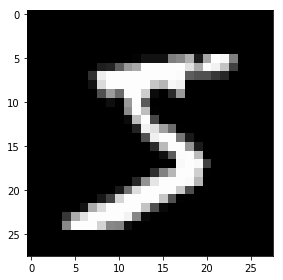

In [5]:
imshow(train_images[0])

In [6]:
def img_to_float(img):
    return (np.float32(img)[..., None]-127.5)/127.5
def img_to_uint8(img):
    return np.uint8(img*127.5+128).clip(0, 255)[...,0]

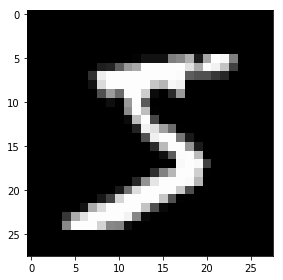

In [7]:
train_img_f32 = img_to_float(train_images)
imshow(img_to_uint8(train_img_f32[0]))

**Add labels to the dataset**
```python
train_dataset_y = tf.data.Dataset.from_tensor_slices(train_labels).map(lambda y: tf.one_hot(y, 10))
train_dataset_x = tf.data.Dataset.from_tensor_slices(train_img_f32)
train_dataset = tf.data.Dataset.zip((train_dataset_x, train_dataset_y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
```





In [8]:
BUFFER_SIZE = train_img_f32.shape[0]
BATCH_SIZE = 32
train_dataset_y = tf.data.Dataset.from_tensor_slices(train_labels).map(lambda y: tf.one_hot(y, 10))
train_dataset_x = tf.data.Dataset.from_tensor_slices(train_img_f32)
train_dataset = tf.data.Dataset.zip((train_dataset_x, train_dataset_y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

**The generator network is modified to take two inputs, labels and noises.
Two inputs are concat into one before sending to the original generator.**


In [9]:
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Input, concatenate
from tensorflow.keras import Model
latent_dim = 100

_0 = Input((latent_dim,))
_1 = Input((10,))
_ = concatenate([_0, _1])
_ = Dense(7*7*256, use_bias=False, input_shape=(latent_dim,))(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Reshape((7, 7, 256))(_)
_ = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')(_)
generator = Model(inputs=[_0,_1], outputs=_)

**The discriminator also take two inputs, labels and images. The labels are concat to the flatten layer in later stage.**

In [10]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten
_0 = Input((28,28, 1))
_1 = Input((10,))
_ = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(_0)
_ = LeakyReLU()(_)
_ = Dropout(0.3)(_)
_ = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(_)
_ = LeakyReLU()(_)
_ = Dropout(0.3)(_)
_ = Flatten()(_)
_ = concatenate([_, _1])
_ = Dense(50)(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Dense(1)(_)
discriminator = Model(inputs=[_0,_1], outputs=_)

In [11]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(generated_output):
    return loss_fn(tf.ones_like(generated_output), generated_output)

In [12]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = loss_fn(tf.ones_like(real_output), real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = loss_fn(tf.zeros_like(generated_output), generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
EPOCHS = 50
num_examples_to_generate = 20

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 latent_dim])
condition_vector_generation = tf.one_hot(list(range(10))+list(range(10)), 10)

In [15]:
@tf.function
def train_step(images, labels):
    # generating noise from a normal distribution
    noise = tf.random.normal([BATCH_SIZE, latent_dim])  
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)
      
        real_output = discriminator([images, labels], training=True)
        generated_output = discriminator([generated_images, labels], training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
for epoch in range(15):
    start_time = time.time()
    for images, labels in train_dataset:
        train_step(images, labels)
    fake = generator([random_vector_for_generation, condition_vector_generation], training=False)
    fake_concat = np.transpose(img_to_uint8(fake), [1,0,2]).reshape((28,-1))
    print(epoch, time.time()-start_time)
    display(PIL.Image.fromarray(fake_concat))
  
  

0 16.848364114761353


1 12.175549507141113


2 11.367757797241211


3 11.38961124420166


4 11.278191566467285


5 11.328220844268799


6 11.35372543334961


7 11.041415691375732


8 11.560566186904907


9 11.870312929153442


10 11.144068956375122


11 11.821977615356445


12 11.558624505996704


13 11.609253644943237


14 11.420289993286133
